# 1. Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, accuracy_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import os.path
import pickle

# 2. Definições

In [17]:
IMAGES_PATH = "../reports/figures/"
PATH_INPUT_DATASET = "../data/processed/internacoes_processado.csv"
PATH_BEST_MODELS = "./models/best_models.pkl"

style_dict = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlesize": "large"
}

sns.set_theme(
    context="paper",
    style="ticks",
    palette="hls",
    rc=style_dict
)

# 3. Funções de apoio

In [18]:

def salvar_figura(fig, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH + f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    print(f'Salvando figura {fig_id}...')
    fig.savefig(path, format=fig_extension, dpi=resolution)

def obter_nomes_colunas_por_tipo(df, numeric=False):
    if numeric:
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    else:
        return list(df.select_dtypes(include=['object']).columns)

def plotar_features_categoricas(df, target_column, categorical_features):
    for feature in categorical_features:
        sns.countplot(x=feature, data=df, hue=target_column)
        plt.show()
        plt.clf()
    plt.tight_layout()
    

# 4. Análise

In [19]:
df = pd.read_csv(PATH_INPUT_DATASET)

X = df.drop("reinternacao", axis=1)
y = df["reinternacao"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

df_train = X_train.merge(y_train, left_index=True, right_index=True)
df_test = X_test.merge(y_test, left_index=True, right_index=True)

## 4.1 Análise Univariada

### 4.1.1 Distribuições de Variáveis Categóricas

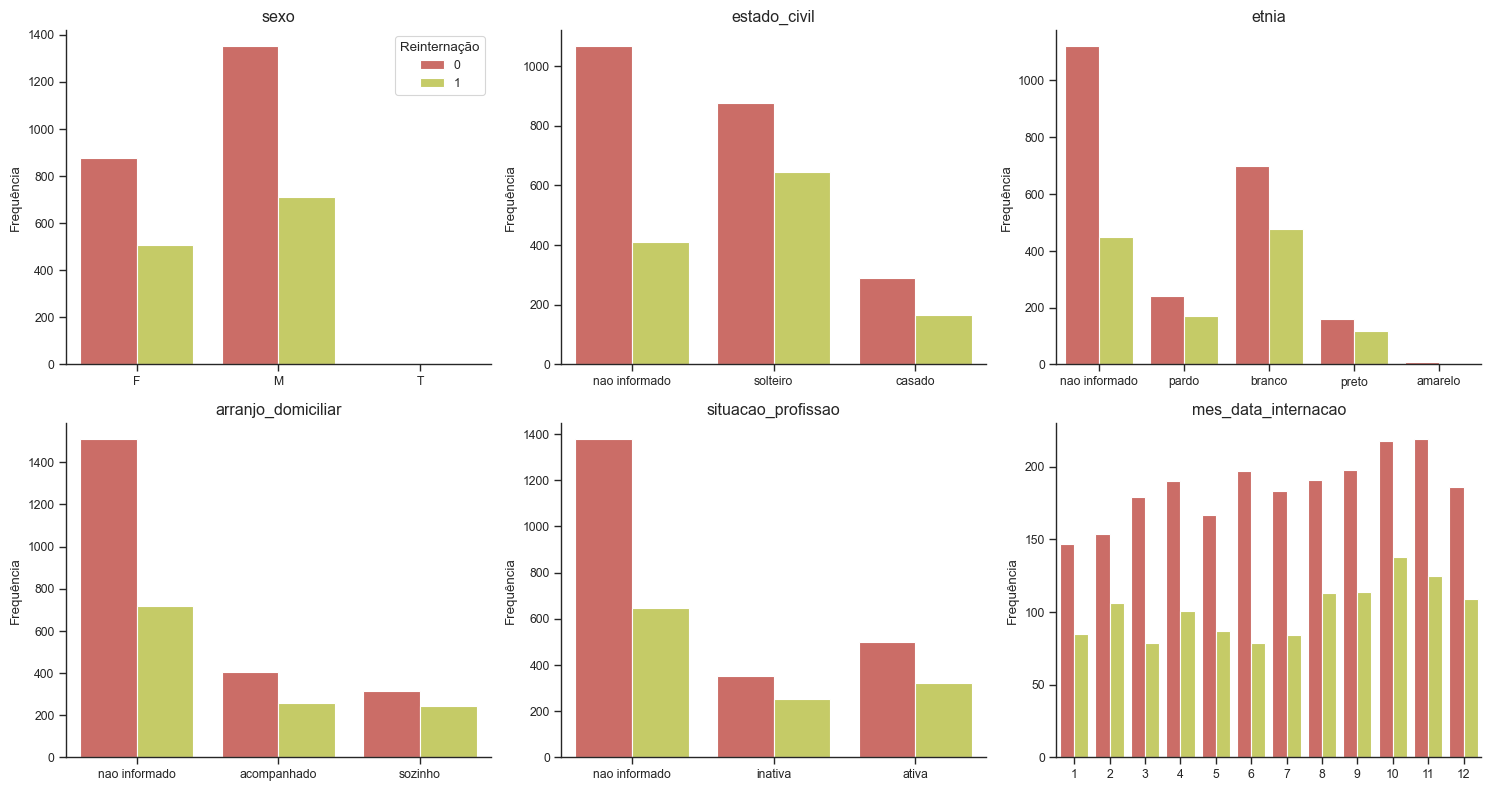

In [13]:
vars = ["sexo", "estado_civil", "etnia", "arranjo_domiciliar", "situacao_profissao", "mes_data_internacao"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, var in zip(axes, vars):
    sns.countplot(x=var, data=df_train, ax=ax, hue="reinternacao")
    ax.set_title(var)
    ax.set_xlabel("")
    ax.set_ylabel("Frequência")
    ax.legend().remove()

plt.tight_layout()
# axes[-1].axis("off")
axes[0].legend(title="Reinternação");

# 5. Treinamento e Seleção de Modelos

## 5.1 Definição do preprocessor

In [20]:
class CyclicalDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name, period):
        self.column_name = column_name
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column_name + '_sin'] = np.sin(2 * np.pi * X[self.column_name] / self.period)
        X_copy[self.column_name + '_cos'] = np.cos(2 * np.pi * X[self.column_name] / self.period)
        X_copy = X_copy.drop(self.column_name, axis=1)
        return X_copy

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['idade_data_internacao', 'tempo_internacao_horas']),
        ('ciclico_diasemana', CyclicalDateTransformer('dia_semana_data_internacao', 7), ['dia_semana_data_internacao']),
        ('ciclico_mes', CyclicalDateTransformer('mes_data_internacao', 12), ['mes_data_internacao']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['sexo', 'estado_civil', 'etnia', 'arranjo_domiciliar', 'situacao_profissao', 'cid_diagnostico_grupo_chave']),
    ],
    remainder='passthrough'
)

## 5.2 Undersampling para balancear a variável resposta

In [25]:
print("Antes do undersampling (conjunto de treinamento):", Counter(y_train))
print("Antes do undersampling (conjunto de teste):", Counter(y_test))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)

print("Após o undersampling (conjunto de treinamento):", Counter(y_train_resampled))
print("Após o undersampling (conjunto de teste):", Counter(y_test_resampled))

Antes do undersampling (conjunto de treinamento): Counter({0: 2229, 1: 1220})
Antes do undersampling (conjunto de teste): Counter({0: 731, 1: 419})
Após o undersampling (conjunto de treinamento): Counter({0: 1220, 1: 1220})
Após o undersampling (conjunto de teste): Counter({0: 419, 1: 419})


## 5.3 Definição dos modelos e hiperparâmetros

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = [
    ('RandomForest', RandomForestClassifier(), {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt'],
        'model__bootstrap': [True, False]
    }),
    ('GradientBoosting', GradientBoostingClassifier(), {
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt']
    }),
    ('LogisticRegression', LogisticRegression(solver='liblinear'), {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 1500, 2000]
    }),
    ('XGB', XGBClassifier(), {
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3, 5],
        'model__gamma': [0.0, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5, 1]
    }),
    ('LGBM', LGBMClassifier(), {
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__min_child_samples': [5, 10, 20],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5, 1]
    }),
    ('SVM', SVC(probability=True), {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'poly'],
        'model__gamma': ['scale', 'auto']
    }),
    ('KNN', KNeighborsClassifier(), {
        'model__n_neighbors': [3, 5, 7, 9, 11],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__p': [1, 2]
    })    
]

## 5.4 Treinamento sem tunagem de hiperparâmetros

In [27]:
results_without_tunning = {}

for model_name, model, _ in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    scores = cross_validate(pipeline, X_train_resampled, y_train_resampled, cv=cv, scoring=['accuracy', 'precision', 'recall', 'roc_auc'], n_jobs=-1)
    accuracy_scores  = scores['test_accuracy']
    precision_scores = scores['test_precision']
    recall_scores    = scores['test_recall']
    auc_scores = scores['test_roc_auc']

    results_without_tunning[model_name] = [accuracy_scores.mean(), precision_scores.mean(), recall_scores.mean(), auc_scores.mean()]

results_without_tunning = pd.DataFrame(results_without_tunning, index=["Acurácia", "Precisão", "Recall", "AUC"]).T.reset_index().rename(columns={"index": "Model"})

results_without_tunning

,Model,Acurácia,Precisão,Recall,AUC
0,RandomForest,0.529918,0.530315,0.528689,0.546703
1,GradientBoosting,0.552459,0.552024,0.557377,0.576092
2,LogisticRegression,0.554918,0.555197,0.547541,0.581769
3,XGB,0.542623,0.543124,0.539344,0.552466
4,LGBM,0.544672,0.544851,0.537705,0.560659
5,SVM,0.554918,0.557095,0.536066,0.583476
6,KNN,0.524590,0.524728,0.522131,0.532102


In [28]:
for model_name, model, _ in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(4, 4))

    for i, (train, test) in enumerate(cv.split(X_train_resampled, y_train_resampled)):
        pipeline.fit(X_train_resampled.iloc[train], y_train_resampled.iloc[train])
        y_pred_proba = pipeline.predict_proba(X_train_resampled.iloc[test])[:, 1]

        fpr, tpr, thresholds = roc_curve(y_train_resampled.iloc[test], y_pred_proba)
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=1, alpha=0.8, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label=f'Média ROC (AUC = {mean_auc:.2f})')

    ax.set_xlabel('Taxa de Falso Positivo')
    ax.set_ylabel('Taxa de Verdadeiro Positivo')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend(loc='lower right')
    
    salvar_figura(fig, f'Curva ROC - {model_name}')
    fig.clear()

Salvando figura Curva ROC - RandomForest...
Salvando figura Curva ROC - GradientBoosting...
Salvando figura Curva ROC - LogisticRegression...
Salvando figura Curva ROC - XGB...
Salvando figura Curva ROC - LGBM...
Salvando figura Curva ROC - SVM...
Salvando figura Curva ROC - KNN...


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

## 5.5 Treinamento com tunagem de hiperparâmetros

In [29]:
if os.path.isfile(PATH_BEST_MODELS):
    with open(PATH_BEST_MODELS, 'rb') as f:
        best_models = pickle.load(f)
    print("Modelos carregados com sucesso!")
else:
    results_with_tunning = {}
    best_params_dict = {}
    best_models = {}

    for model_name, model, params in models:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Configurando GridSearchCV para buscar os melhores hiperparâmetros
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring=['accuracy', 'precision', 'recall', 'roc_auc'], refit='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Avaliando o desempenho do modelo com os melhores hiperparâmetros usando validação cruzada
        accuracy_scores = grid_search.cv_results_['mean_test_accuracy']
        precision_scores = grid_search.cv_results_['mean_test_precision']
        recall_scores = grid_search.cv_results_['mean_test_recall']
        auc_scores = grid_search.cv_results_['mean_test_roc_auc']

        best_params_dict[model_name] = grid_search.best_params_

        results_with_tunning[model_name] = [accuracy_scores.mean(), precision_scores.mean(), recall_scores.mean(),  auc_scores.mean()]
        best_models[model_name] = grid_search.best_estimator_

    results_with_tunning = pd.DataFrame(results_with_tunning, index=["Acurácia_Tunagem", "Precisão_Tunagem", "Recall_Tunagem", "AUC_Tunagem"]).T.reset_index().rename(columns={"index": "Model"})

    with open(PATH_BEST_MODELS, 'wb') as f:
        pickle.dump(best_models, f)
    print("Modelos treinados e salvo com sucesso!")
    
    results_with_tunning

Modelos treinados e salvo com sucesso!


# 6. Validação

## 6.1 Validação no conjunto de teste

In [31]:
results_test = {}
roc_curve_test = {}

for model_name, model in best_models.items():
    
    model.fit(X_test_resampled, y_test_resampled)
    y_pred = model.predict(X_test_resampled)
    y_prob = model.predict_proba(X_test_resampled)[:, 1]

    accuracy  = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)
    auc_score = roc_auc_score(y_test_resampled, y_prob)
    fpr, tpr, _ = roc_curve(y_test_resampled, y_prob)

    results_test[model_name] = [accuracy, precision, recall, auc_score]
    roc_curve_test[model_name] = (fpr, tpr)

results_test = pd.DataFrame(results_test, index=["Acurácia_Teste", "Precisão_Teste", "Recall_Teste", "AUC_Teste"]).T.reset_index().rename(columns={"index": "Model"})

results_test

c:\Users\matba\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,Model,Acurácia_Teste,Precisão_Teste,Recall_Teste,AUC_Teste
0,RandomForest,0.874702,0.865116,0.887828,0.949983
1,GradientBoosting,0.749403,0.721868,0.811456,0.821304
2,LogisticRegression,0.560859,0.568365,0.505967,0.582880
3,XGB,0.736277,0.722973,0.766110,0.806905
4,LGBM,0.729117,0.707792,0.780430,0.803484
5,SVM,0.526253,0.513959,0.966587,0.460971
6,KNN,0.634845,0.625277,0.673031,0.668557


In [32]:
results_without_tunning.merge(results_with_tunning, on='Model', how='left').merge(results_test, on='Model', how='left').to_csv('model_selection_results.csv', index=False)

## 6.2 Curvas ROC

Salvando figura curva_roc_modelos_sem_tunagem_hiperparametros...


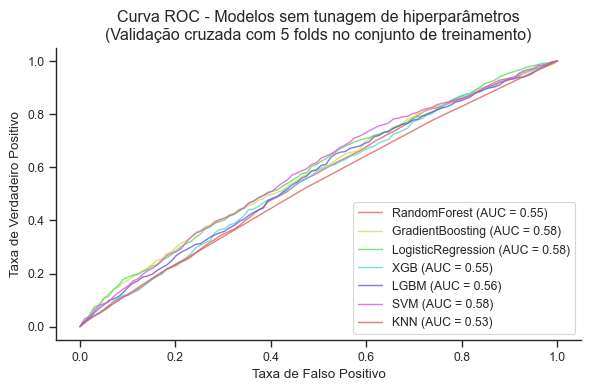

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))

for model_name, model, _ in models:

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X_train_resampled, y_train_resampled)):
            pipeline.fit(X_train_resampled.iloc[train], y_train_resampled.iloc[train])
            y_pred_proba = pipeline.predict_proba(X_train_resampled.iloc[test])[:, 1]

            fpr, tpr, thresholds = roc_curve(y_train_resampled.iloc[test], y_pred_proba)
            mean_tpr += np.interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = auc(fpr, tpr)

    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    ax.plot(mean_fpr, mean_tpr, lw=1, alpha=0.8, label=f'{model_name} (AUC = {mean_auc:.2f})')

ax.set_title("Curva ROC - Modelos sem tunagem de hiperparâmetros\n(Validação cruzada com 5 folds no conjunto de treinamento)")
ax.set_xlabel('Taxa de Falso Positivo')
ax.set_ylabel('Taxa de Verdadeiro Positivo')
ax.legend(loc="lower right");
salvar_figura(fig, 'curva_roc_modelos_sem_tunagem_hiperparametros')

Salvando figura curva_roc_modelos_com_tunagem_hiperparametros...


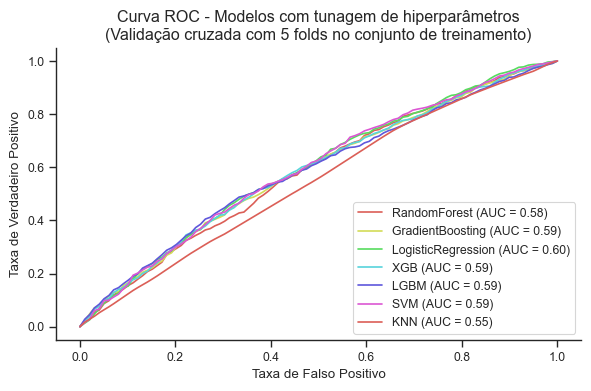

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
for model_name, pipeline in best_models.items():

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X_train_resampled, y_train_resampled)):
            pipeline.fit(X_train_resampled.iloc[train], y_train_resampled.iloc[train])
            y_pred_proba = pipeline.predict_proba(X_train_resampled.iloc[test])[:, 1]

            fpr, tpr, thresholds = roc_curve(y_train_resampled.iloc[test], y_pred_proba)
            mean_tpr += np.interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = auc(fpr, tpr)

    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    RocCurveDisplay(fpr=mean_fpr, tpr=mean_tpr, roc_auc=mean_auc).plot(name=model_name, ax=ax)

ax.set_title("Curva ROC - Modelos com tunagem de hiperparâmetros\n(Validação cruzada com 5 folds no conjunto de treinamento)")
ax.set_xlabel('Taxa de Falso Positivo')
ax.set_ylabel('Taxa de Verdadeiro Positivo');
salvar_figura(fig, 'curva_roc_modelos_com_tunagem_hiperparametros')

Salvando figura curva_roc_modelos_teste...


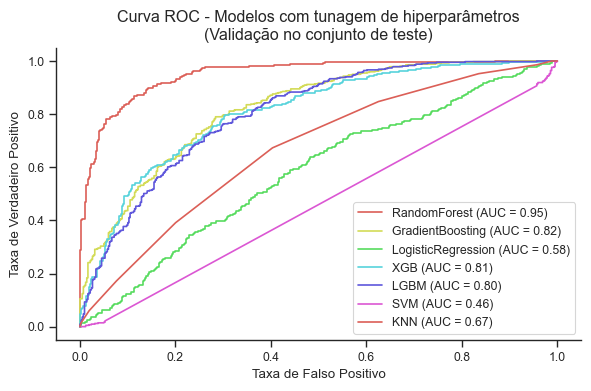

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))

for model_name, (fpr, tpr) in roc_curve_test.items():
    auc_score = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score).plot(name=model_name, ax=ax)

ax.set_title("Curva ROC - Modelos com tunagem de hiperparâmetros\n(Validação no conjunto de teste)")
ax.set_xlabel('Taxa de Falso Positivo')
ax.set_ylabel('Taxa de Verdadeiro Positivo');
salvar_figura(fig, 'curva_roc_modelos_teste')